In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install pyyaml==5.1
#!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
#install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# After this step it will ask you to restart the runtime, please do it.

In [1]:
import torch
assert torch.__version__.startswith("1.8") 
import torchvision
import cv2
import os
import numpy as np
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import ColorMode

#in case of augmentation
#from detectron2.data import build_detection_test_loader, build_detection_train_loader
#from detectron2.data import detection_utils as utils
#import detectron2.data.transforms as T
#import copy

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("cat_train", {}, "key_data/train.json", "key_data/img")
register_coco_instances("cat_test", {}, "key_data/test.json", "key_data/img")

In [3]:
'''
def get_data_dicts(directory, classes):
    dataset_dicts = []
    cnt=0
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)
        record = {}
        filename = os.path.join(directory, img_anns["imagePath"])
        record["file_name"] = filename
        ########################check your image and replace this two
        record["height"] = 736       ##########image size
        record["width"] = 1920  
        record["image_id"]=cnt  
        #record["name"]="fish"
        
        #objjs = []
        #objj = {"id": cnt,"file_name": filename,"height": 736,"width": 1920}
        #objjs.append(objj)
        #record["images"] = objjs

        annos = img_anns["shapes"]
        objs = []
        pxx=[]
        pyy=[]
        #print('annos 2 is',annos[2])
        iii=0
        for anno in annos:
          if(iii==0):
            px = [a[0] for a in anno['points']] # x coord
            #print('px vlues are',px)
            py = [a[1] for a in anno['points']] # y-coord
            poly = [(x, y) for x, y in zip(px, py)] # poly for segmentation
            poly = [p for x in poly for p in x]
            #print('for i',iii)
            iii=iii+1
          else:
            iii=iii+1  
            if(iii>5):  ###########orignal 5
              pxi = [a[0] for a in anno['points']] # x coord
              pyi = [a[1] for a in anno['points']] # y-coord
              pt = [(x, y) for x, y in zip(pxi, pyi)] # poly for segmentation
              pt = [p for x in pt for p in x]
              pxx.append(pt[0])
              #print('px array values are for y',pt[1])
              #print('px vlues are',pxx)
              pyy.append(pt[1])
              #print('for i',iii)
        bx=[np.min(px), np.min(py), np.max(px), np.max(py)]      
        key_pt=[pxx[0],pyy[0],2,pxx[1],pyy[1],2,pxx[2],pyy[2],2,pxx[3],pyy[3],2,pxx[4],pyy[4],2,pxx[5],pyy[5],2,pxx[6],pyy[6],2]
        #key_pt=[100,200,2,150,250,2,50,50,2,200,200,2,450,250,2,50,50,2,350,350,2]
        print('bx is',bx,'keypoint is',key_pt)
        obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "keypoints":[key_pt],
                "id":cnt,
                "category_id":0, #classes.index(anno['label']),
                "iscrowd": 0,
                "num_keypoints":7
              }
        objs.append(obj)
        record["annotations"] = objs
        print('record is',record)
        dataset_dicts.append(record)
        cnt=cnt+1
    return dataset_dicts
'''
print('done')

done


In [4]:
#classes = ['fish','bh','bl','fl','sh','np','fp','tp','bhu','bhl','shu','shl']

#keypoint_names = ['np','fp','tp','bhu','bhl','shu','shl']
#keypoint_flip_map = [('np','fp'), ('np','tp'), ('bhu','bhl'),('shu','shl')]
classes = ["fish"]   #####or any other parameter 
from detectron2.data import MetadataCatalog

MetadataCatalog.get("cat_train").set(thing_classes=classes)
#classs = MetadataCatalog.get("cat_train").thing_classes = ["fish"]
#print(classs)


namespace(name='cat_train',
          json_file='key_data/train.json',
          image_root='key_data/img',
          evaluator_type='coco',
          thing_classes=['fish'])

In [5]:
#############apply data augentation in images##############################
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
import detectron2.data.transforms as T
import copy
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
                      T.RandomContrast(0.5, 1.5),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      #T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [6]:
#keypoint_names =['np','fp','tp','bhu','bhl','shu','shl']
keypoint_names =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
keypoint_flip_map = [('18','1')]
MetadataCatalog.get("cat_train").thing_classes = ["fish"]
MetadataCatalog.get("cat_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("cat_train").keypoint_names = keypoint_names
MetadataCatalog.get("cat_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("cat_train").evaluator_type="coco"
MetadataCatalog.get("cat_train").keypoint_connection_rules = [('1','4', (155, 0, 55)),('2','3', (0, 255, 55)),('9','11', (255, 255, 255)),('1','18', (255, 0, 155)), ('5','7', (0, 155, 255)), ('1','2', (155, 255, 0)) ]
#MetadataCatalog.get("cat_train").keypoint_connection_rules = [('1','18', (0, 0, 255)), ('11','9', (0, 0, 255)), ('10','11', (0, 255, 0)) ]

In [7]:
dataset_dicts = DatasetCatalog.get("cat_train")
#dataset_dicts

[01/24 11:12:52 d2.data.datasets.coco]: Loaded 400 images in COCO format from key_data/train.json


key_data/img/2022-04-11-11-00-36_right.jpg_0.png


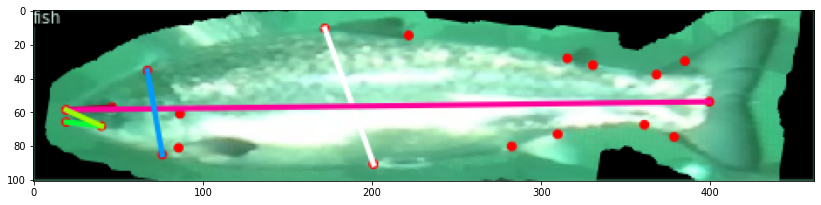

key_data/img/2022-04-11-09-42-59_right.jpg_1.png


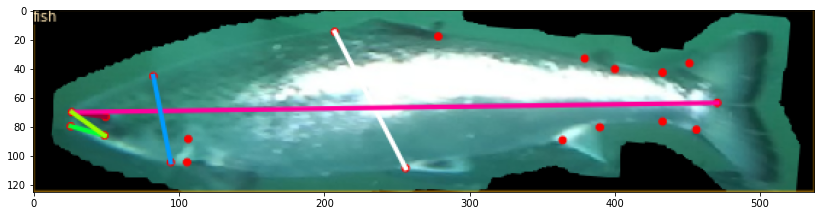

key_data/img/2022-04-11-02-18-55_right.jpg_10.png


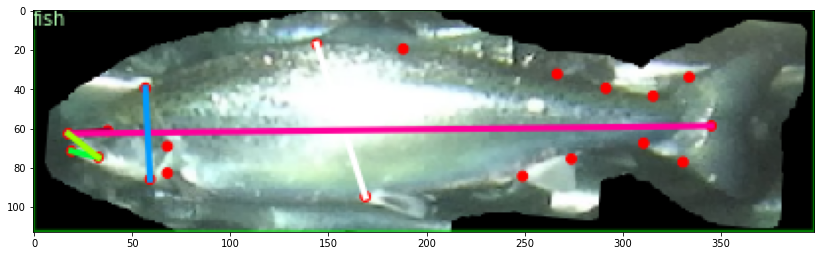

In [8]:
#trn_path = '/content/drive/MyDrive/dataset/fish_data_seg/data/train' 
#classes = ['fish']
#dataset_dicts = get_data_dicts(trn_path,classes)

import random
from detectron2.utils.visualizer import Visualizer
fish_metadata = MetadataCatalog.get("cat_train")
for d in random.sample(dataset_dicts, 3):
    print(d['file_name'])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fish_metadata, scale=0.8)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()th
    

In [9]:
#dataset_dicts = DatasetCatalog.get("category_test")
#dataset_dicts


In [10]:
#### from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml")) #keypoint_rcnn_R_50_FPN_3x.yaml")) 
#cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("cat_train",)
cfg.DATASETS.TEST = ()#("category_test")
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml") #keypoint_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4   #orignal 2
cfg.SOLVER.GAMMA = 0.5
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000   # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = []  # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # hand , fish    ####number of class

####################################################extra#############################
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 20     ########number of key points
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((20, 1), dtype=float).tolist()
#############################################################################

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer = AugTrainer(cfg)
trainer.resume_or_load(resume=False)


[01/24 11:13:20 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.keypoint_head.score_lowres.weight' to the model due to incompatible shapes: (512, 17, 4, 4) in the checkpoint but (512, 20, 4, 4) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.keypoint_head.score_lowres.bias' to the model due to incompatible shapes: (17,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.keypoint_head.score_lowres.{bias, weight}


In [11]:
########for checking######################
cls = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
print('NetworkModel category:%d'%( len(cls)))
print(cls)

kname = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).keypoint_names
print('keypoint_names')
print(kname)

#krule = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).keypoint_connection_rules
#print('keypoint_connection_rules')
#print(krule)

################################################################

NetworkModel category:1
['fish']
keypoint_names
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [12]:
#trainer.train()

[01/24 11:13:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
[01/24 11:13:31 d2.data.datasets.coco]: Loaded 68 images in COCO format from key_data/test.json
tensor([[[2.9941e+01, 9.5856e+01, 4.8198e-01],
         [6.1638e+01, 1.1146e+02, 9.0949e-01],
         [3.0414e+01, 1.0863e+02, 5.7874e-01],
         [8.7657e+01, 9.5856e+01, 5.5431e-01],
         [1.2598e+02, 4.5719e+01, 4.2835e-01],
         [1.6997e+02, 9.9167e+01, 5.6596e-01],
         [1.3213e+02, 1.3417e+02, 6.1816e-01],
         [1.6477e+02, 1.3086e+02, 7.4001e-01],
         [2.8399e+02, 2.3488e+01, 1.1412e+00],
         [3.5211e+02, 3.2002e+01, 4.7141e-01],
         [3.2657e+02, 1.3890e+02, 1.3063e+00],
         [4.3916e+02, 1.2092e+02, 1.9542e+00],
         [4.7228e+02, 1.0768e+02, 7.4117e-01],
         [4.6092e+02, 5.4232e+01, 4.1864e-01],
         [4.8269e+02, 5.9908e+01, 5.0048e-01],
         [5.1060e+02, 6.1800e+01, 5.3120e-01],
         [5.4040e+02, 4.3827e+01,

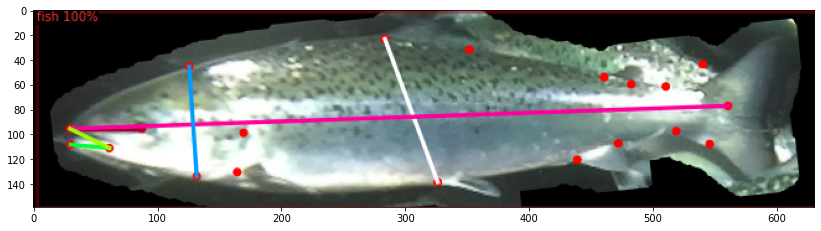

ii is 1
tensor([[[3.5167e+01, 7.6150e+01, 5.9739e-01],
         [6.5021e+01, 9.7921e+01, 1.0291e+00],
         [3.5673e+01, 9.0833e+01, 5.8011e-01],
         [6.7551e+01, 8.1213e+01, 1.1662e+00],
         [1.1208e+02, 4.2734e+01, 7.6263e-01],
         [1.5205e+02, 9.3364e+01, 4.4097e-01],
         [1.2726e+02, 1.2273e+02, 1.0027e+00],
         [1.4699e+02, 1.1868e+02, 6.8483e-01],
         [2.8209e+02, 1.6912e+01, 5.8072e-01],
         [3.5344e+02, 2.2988e+01, 7.4923e-01],
         [3.3927e+02, 1.3539e+02, 1.1389e+00],
         [4.4958e+02, 1.1615e+02, 1.2129e+00],
         [4.8702e+02, 1.0400e+02, 6.4199e-01],
         [4.9512e+02, 5.0328e+01, 1.2661e+00],
         [5.2244e+02, 5.9948e+01, 6.5439e-01],
         [5.5837e+02, 7.0074e+01, 7.6986e-01],
         [5.8316e+02, 6.2480e+01, 4.4829e-01],
         [5.9176e+02, 9.6402e+01, 1.5403e+00],
         [5.6849e+02, 1.1210e+02, 1.6190e+00],
         [5.4724e+02, 1.0147e+02, 8.6157e-01]]], device='cuda:0')
ii is 1


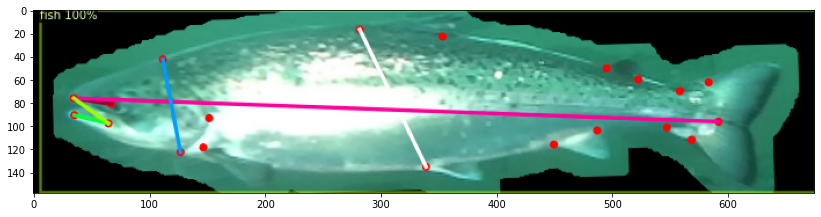

ii is 2
tensor([[[2.6858e+01, 8.8740e+01, 6.3526e-01],
         [5.4405e+01, 1.0663e+02, 1.0144e+00],
         [3.0072e+01, 1.0066e+02, 8.7019e-01],
         [5.3946e+01, 9.0574e+01, 1.3787e+00],
         [8.5625e+01, 6.1682e+01, 6.7588e-01],
         [1.1363e+02, 1.0204e+02, 4.7665e-01],
         [9.9398e+01, 1.2910e+02, 1.5034e+00],
         [1.1179e+02, 1.2635e+02, 9.8894e-01],
         [2.2979e+02, 2.9121e+01, 1.0312e+00],
         [2.9728e+02, 3.4166e+01, 7.3292e-01],
         [2.7294e+02, 1.3643e+02, 2.2933e+00],
         [3.7579e+02, 1.1580e+02, 1.2220e+00],
         [4.1022e+02, 1.0387e+02, 7.8752e-01],
         [4.1527e+02, 4.9300e+01, 9.9019e-01],
         [4.4649e+02, 5.6179e+01, 9.4292e-01],
         [4.8230e+02, 6.1682e+01, 1.1383e+00],
         [5.0709e+02, 5.1134e+01, 4.5519e-01],
         [5.2454e+02, 8.0944e+01, 8.4568e-01],
         [4.9929e+02, 1.0433e+02, 1.1826e+00],
         [4.7312e+02, 9.4243e+01, 6.3176e-01]]], device='cuda:0')
ii is 2


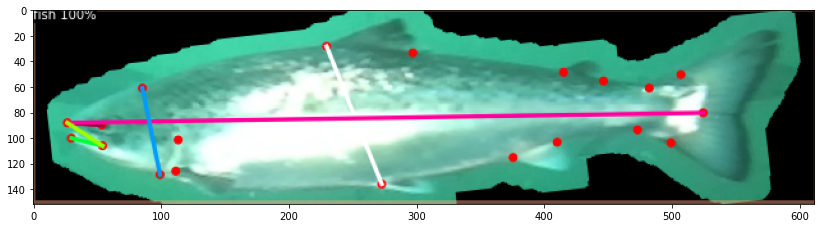

ii is 3
tensor([[[3.2056e+01, 8.4658e+01, 8.0170e-01],
         [5.9448e+01, 9.8332e+01, 9.1101e-01],
         [2.9236e+01, 9.4713e+01, 5.9705e-01],
         [6.3879e+01, 8.6669e+01, 6.1374e-01],
         [9.1272e+01, 5.2484e+01, 5.4104e-01],
         [1.3961e+02, 8.9082e+01, 8.1712e-01],
         [1.2753e+02, 1.1522e+02, 6.7365e-01],
         [1.4444e+02, 1.1160e+02, 8.5924e-01],
         [2.4515e+02, 2.1114e+01, 6.3159e-01],
         [3.0437e+02, 2.7951e+01, 5.2779e-01],
         [2.8463e+02, 1.1201e+02, 6.5538e-01],
         [3.8292e+02, 9.6321e+01, 9.1348e-01],
         [4.1514e+02, 8.6669e+01, 8.2631e-01],
         [4.1313e+02, 4.2832e+01, 7.4669e-01],
         [4.3287e+02, 4.9669e+01, 8.0024e-01],
         [4.5059e+02, 5.4897e+01, 8.0477e-01],
         [4.7114e+02, 4.7658e+01, 4.3711e-01],
         [4.7960e+02, 7.0582e+01, 7.6115e-01],
         [4.6348e+02, 8.6267e+01, 4.4017e-01],
         [4.4616e+02, 8.1843e+01, 4.5986e-01]]], device='cuda:0')
ii is 3


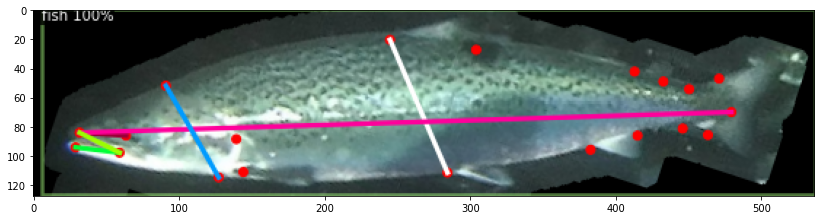

ii is 4
tensor([[[3.1626e+01, 1.0017e+02, 4.4270e-01],
         [5.6143e+01, 1.1438e+02, 1.1301e+00],
         [3.2117e+01, 1.0948e+02, 7.0105e-01],
         [5.0259e+01, 1.0164e+02, 4.7257e-01],
         [8.3111e+01, 6.6372e+01, 7.0304e-01],
         [1.1547e+02, 1.0703e+02, 7.7627e-01],
         [1.0321e+02, 1.3005e+02, 1.4992e+00],
         [1.1351e+02, 1.2858e+02, 9.7132e-01],
         [2.2236e+02, 2.6696e+01, 1.1133e+00],
         [2.9248e+02, 3.1594e+01, 8.6258e-01],
         [2.6797e+02, 1.3789e+02, 3.3581e+00],
         [3.9349e+02, 1.2368e+02, 3.0213e+00],
         [4.3909e+02, 1.1242e+02, 9.4327e-01],
         [4.3223e+02, 5.4616e+01, 1.1201e+00],
         [4.7341e+02, 6.5882e+01, 1.0418e+00],
         [5.2294e+02, 7.4699e+01, 7.6556e-01],
         [5.4892e+02, 6.5882e+01, 4.5778e-01],
         [5.8080e+02, 1.0066e+02, 7.2419e-01],
         [5.5040e+02, 1.2564e+02, 1.0093e+00],
         [5.1509e+02, 1.1438e+02, 6.6493e-01]]], device='cuda:0')
ii is 4


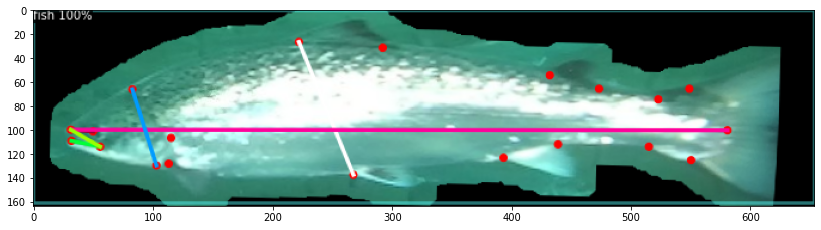

ii is 5
tensor([[[3.9797e+01, 1.2081e+02, 6.5068e-01],
         [7.1480e+01, 1.3692e+02, 1.1617e+00],
         [4.0353e+01, 1.3303e+02, 6.5468e-01],
         [7.9262e+01, 1.2136e+02, 5.5701e-01],
         [1.1095e+02, 7.1375e+01, 4.7186e-01],
         [1.6153e+02, 1.2025e+02, 4.9893e-01],
         [1.4708e+02, 1.5191e+02, 8.8666e-01],
         [1.6820e+02, 1.4914e+02, 7.7057e-01],
         [2.9160e+02, 2.6384e+01, 8.8059e-01],
         [3.8442e+02, 3.4715e+01, 8.0024e-01],
         [3.4829e+02, 1.4525e+02, 7.8671e-01],
         [4.7280e+02, 1.3525e+02, 8.0294e-01],
         [5.1727e+02, 1.2803e+02, 8.7937e-01],
         [5.2672e+02, 7.5818e+01, 5.7557e-01],
         [5.5729e+02, 8.5816e+01, 1.3355e+00],
         [5.9842e+02, 9.6370e+01, 8.4701e-01],
         [6.3344e+02, 9.0260e+01, 4.4406e-01],
         [6.4512e+02, 1.2470e+02, 7.2674e-01],
         [6.1955e+02, 1.4692e+02, 6.3486e-01],
         [5.9342e+02, 1.3303e+02, 4.9389e-01]]], device='cuda:0')
ii is 5


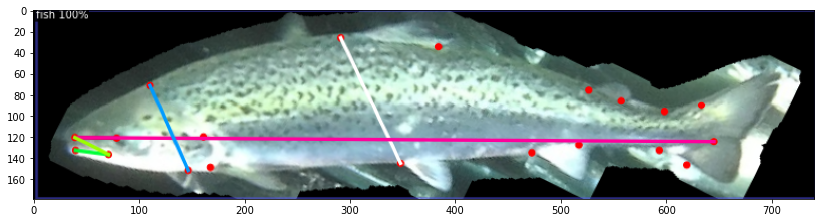

ii is 6
output length is is [[ 35.77708764  31.144823    58.         531.30499715]
 [ 36.61966685  30.8058436   32.38826948 556.35959594]
 [ 33.28663395  24.73863375  27.07397274 498.06425288]
 [ 30.41381265  30.2654919   31.06444913 447.21918563]
 [ 28.65309756  24.51530134  19.02629759 549.        ]
 [ 35.77708764  31.144823    40.01249805 606.01320118]]


In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("cat_test", )

#keypoint_names =['np','fp','tp','bhu','bhl','shu','shl']
keypoint_names =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
keypoint_flip_map = [('18','1')]
MetadataCatalog.get("cat_train").thing_classes = ["fish"]
MetadataCatalog.get("cat_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("cat_train").keypoint_names = keypoint_names
MetadataCatalog.get("cat_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("cat_train").evaluator_type="coco"
MetadataCatalog.get("cat_train").keypoint_connection_rules = [('1','4', (155, 0, 55)),('2','3', (0, 255, 55)),('9','11', (255, 255, 255)),('1','18', (255, 0, 155)), ('5','7', (0, 155, 255)), ('1','2', (155, 255, 0)) ]

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("cat_test")

from detectron2.utils.visualizer import ColorMode
import glob
test_dataset_dicts = DatasetCatalog.get("cat_test")
size=(6,4)
len_f=np.zeros(size)
ii=0
for d in random.sample(test_dataset_dicts, 6):
    img = cv2.imread(d["file_name"])      
    #make predictions
    outputs = predictor(img)
    keypt = outputs["instances"].pred_keypoints
    clss = outputs["instances"].pred_classes
    #keypt = outputs["instances"].pred_connection_rules
    print(keypt)
    size=(6,2)
    out_f=np.zeros(size)
    out_f[0,0]=int(keypt[0,0,0])
    out_f[0,1]=int(keypt[0,0,1])
    out_f[1,0]=int(keypt[0,1,0])
    out_f[1,1]=int(keypt[0,1,1])
    out_f[2,0]=int(keypt[0,2,0])
    out_f[2,1]=int(keypt[0,2,1])
    out_f[3,0]=int(keypt[0,3,0])
    out_f[3,1]=int(keypt[0,3,1])
    out_f[4,0]=int(keypt[0,17,0])
    out_f[4,1]=int(keypt[0,17,1])
    len_f[ii,0]=np.sqrt(pow((out_f[0,0]-out_f[1,0]),2)+pow((out_f[0,1]-out_f[1,1]),2)) 
    len_f[ii,1]=np.sqrt(pow((out_f[1,0]-out_f[2,0]),2)+pow((out_f[1,1]-out_f[2,1]),2))
    len_f[ii,2]=np.sqrt(pow((out_f[0,0]-out_f[3,0]),2)+pow((out_f[0,1]-out_f[3,1]),2))
    len_f[ii,3]=np.sqrt(pow((out_f[0,0]-out_f[4,0]),2)+pow((out_f[0,1]-out_f[4,1]),2))
    print('ii is', ii)
    # Use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], metadata = fish_metadata, scale=1)
    #draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    ii=ii+1
    print('ii is', ii)
print('output length is is',len_f)    

In [ ]:
from detectron2.layers import ShapeSpec, nms, cat, cross_entropy, nonzero_tuple
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("cat_test", )

#keypoint_names =['np','fp','tp','bhu','bhl','shu','shl']
keypoint_names =['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20']
keypoint_flip_map = [('18','1')]
MetadataCatalog.get("cat_train").thing_classes = ["fish"]
MetadataCatalog.get("cat_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("cat_train").keypoint_names = keypoint_names
MetadataCatalog.get("cat_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("cat_train").evaluator_type="coco"
MetadataCatalog.get("cat_train").keypoint_connection_rules = [('1','4', (155, 0, 55)),('2','3', (0, 255, 55)),('9','11', (255, 255, 255)),('1','18', (255, 0, 155)), ('5','7', (0, 155, 255)), ('1','2', (155, 255, 0)) ]

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("cat_test")

from detectron2.utils.visualizer import ColorMode
import glob
test_dataset_dicts = DatasetCatalog.get("cat_test")
size=(6,4)
len_f=np.zeros(size)
ii=0
for d in range(1, 4):
    img = cv2.imread('key_data/jaw_defor/T'+str(d)+'.jpg')      
    #make predictions
    outputs = predictor(img)
    keypt = outputs["instances"].pred_keypoints
    clss = outputs["instances"].pred_classes
    scores = outputs['instances'].scores.to("cpu").numpy()
    boxes = outputs["instances"].pred_boxes
    print(scores[0])
    #keypt = outputs["instances"].pred_connection_rules
    print(keyp[0])
    size=(6,2)
    out_f=np.zeros(size)
    nms(boxes = boxes, scores = scores, iou_threshold=0.3)
    #keypt=keypt[0]
    out_f[0,0]=int(keypt[0,0,0])
    out_f[0,1]=int(keypt[0,0,1])
    out_f[1,0]=int(keypt[0,1,0])
    out_f[1,1]=int(keypt[0,1,1])
    out_f[2,0]=int(keypt[0,2,0])
    out_f[2,1]=int(keypt[0,2,1])
    out_f[3,0]=int(keypt[0,3,0])
    out_f[3,1]=int(keypt[0,3,1])
    out_f[4,0]=int(keypt[0,17,0])
    out_f[4,1]=int(keypt[0,17,1])
    len_f[ii,0]=np.sqrt(pow((out_f[0,0]-out_f[1,0]),2)+pow((out_f[0,1]-out_f[1,1]),2)) 
    len_f[ii,1]=np.sqrt(pow((out_f[1,0]-out_f[2,0]),2)+pow((out_f[1,1]-out_f[2,1]),2))
    len_f[ii,2]=np.sqrt(pow((out_f[0,0]-out_f[3,0]),2)+pow((out_f[0,1]-out_f[3,1]),2))
    len_f[ii,3]=np.sqrt(pow((out_f[0,0]-out_f[4,0]),2)+pow((out_f[0,1]-out_f[4,1]),2))
    print('ii is', ii)
    # Use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], metadata = fish_metadata, scale=1)
    #draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    ii=ii+1
    print('ii is', ii)
print('output length is is',len_f)    

In [ ]:
#print(outputs)
cv2.imwrite('otpt.jpg',v.get_image()[:, :, ::-1])
scores = outputs['instances'].scores.to("cpu").numpy()
labels = outputs['instances'].pred_classes .to("cpu").numpy()

boxes = outputs["instances"].pred_boxes
keypt = outputs["instances"].pred_keypoints
clss = outputs["instances"].pred_classes
#keypt = outputs["instances"].pred_connection_rules
print(keypt,scores)
print('class is', clss)
print('boxes is is', boxes)

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"

# load the pre trained model from Detectron2 model zoo
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6 # set a custom testing threshold
#fish_metadata = MetadataCatalog.get("cat_train")
print(fish_metadata)
def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');
    


In [ ]:
predictor = DefaultPredictor(cfg)
#im = cv2.imread("waving.jpg")
#im = cv2.imread("test.jpeg")
im = cv2.imread("test2.jpeg")
outputs = predictor(im)
print(outputs)
o = outputs["instances"]
print("###########################################################")



idxofClass = [i for i, x in enumerate(list(outputs['instances'].pred_classes)) if x == 15]

#Create new class, boxes, scores & masks
classes = o.pred_classes[idxofClass]
scores = o.scores[idxofClass]
boxes = o.pred_boxes[idxofClass]
print('classes, score, box is',classes, scores, boxes)
#masks = o.pred_masks[idxofClass]

#Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
obj = detectron2.structures.Instances(image_size=(480, 640))

obj.set('pred_classes', classes)
obj.set('scores', scores)
obj.set('pred_boxes', boxes)
#obj.set('pred_masks', masks)



In [ ]:
v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
register_coco_instances("valid_data", {}, "key_data/validation.json", "key_data")



In [ ]:
MetadataCatalog.get("valid_data").thing_classes = ["fish"]
pose_metadata = MetadataCatalog.get("valid_data").set(thing_classes=["fish"])
val_dicts = DatasetCatalog.get("valid_data")
print(val_dicts)

In [ ]:
# load the final weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# List of the dataset names for validation. Must be registered in DatasetCatalog
cfg.DATASETS.TEST = ("validation_data", )
# set up predictor
from detectron2.engine import DefaultPredictor
# Create a simple end-to-end predictor with the given config
# that runs on single device for a single input image.
predictor = DefaultPredictor(cfg)
import random
#for drawing predictions on images
from detectron2.utils.visualizer import Visualizer
#to display an image
#randomly select images
ii=0
for d in random.sample(val_dicts, 3):
    img = cv2.imread(d["file_name"])      
    #make predictions
    outputs = predictor(img)
    keypt = outputs["instances"].pred_keypoints
    clss = outputs["instances"].pred_classes
    #keypt = outputs["instances"].pred_connection_rules
    print(keypt)
    size=(5,2)
    out_f=np.zeros(size)
    out_f[0,0]=int(keypt[0,0,0])
    out_f[0,1]=int(keypt[0,0,1])
    out_f[1,0]=int(keypt[0,1,0])
    out_f[1,1]=int(keypt[0,1,1])
    out_f[2,0]=int(keypt[0,2,0])
    out_f[2,1]=int(keypt[0,2,1])
    out_f[3,0]=int(keypt[0,3,0])
    out_f[3,1]=int(keypt[0,3,1])
    out_f[4,0]=int(keypt[0,4,0])
    out_f[4,1]=int(keypt[0,4,1])
    len_f[ii,0]=np.sqrt(pow((out_f[3,0]-out_f[4,0]),2)+pow((out_f[3,1]-out_f[4,1]),2)) 
    len_f[ii,1]=np.sqrt(pow((out_f[0,0]-out_f[2,0]),2)+pow((out_f[0,1]-out_f[2,1]),2))
    len_f[ii,2]=np.sqrt(pow((out_f[0,0]-out_f[1,0]),2)+pow((out_f[0,1]-out_f[1,1]),2))
    ii=ii+1
    print('ii is', ii)
    # Use `Visualizer` to draw the predictions on the image.
    v = Visualizer(img[:, :, ::-1], metadata = fish_metadata, scale=1)
    #draw prediction on image
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()
    ii=ii+1
    print('ii is', ii)
print('output length is is',len_f)    

In [ ]:
# test evaluation
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("valid_data", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "valid_data")
inference_on_dataset(trainer.model, val_loader, evaluator)